In [7]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm

In [8]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [18]:
def plot_score_landscape(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT",
    resolution=100,
    show_scatter=True
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    # Drop rows with NaNs in relevant columns
    df_clean = df[[x_param, y_param, 'score']].dropna()

    x = df_clean[x_param].values
    y = df_clean[y_param].values
    z = df_clean['score'].values

    # Grid for interpolation
    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate: Try 'cubic' but fallback to 'linear' if it fails
    try:
        zi = griddata((x, y), z, (xi, yi), method='cubic')
    except Exception as e:
        print("Cubic interpolation failed, falling back to linear:", e)
        zi = griddata((x, y), z, (xi, yi), method='linear')

    # Setup plot
    plt.rcParams.update({
        "font.family": "serif",
        "axes.titlesize": title_fontsize,
        "axes.labelsize": label_fontsize,
        "xtick.labelsize": tick_fontsize,
        "ytick.labelsize": tick_fontsize,
        "figure.dpi": dpi,
        "axes.grid": True,
        "grid.color": "#999999",
        "grid.alpha": 0.2,
        "grid.linestyle": "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, alpha=alpha)

    if show_scatter:
        sc = ax.scatter(x, y, c=z, cmap=cmap, edgecolor='k', marker='o', alpha=1.0)

    ax.set_title(title)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    ax.set_xlim(0,0.03)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()


In [10]:
# Set the file path:
path = "results/"
file_name = "result_GridSearch_ST_max.jsonl"
df = parse_results(path + file_name)

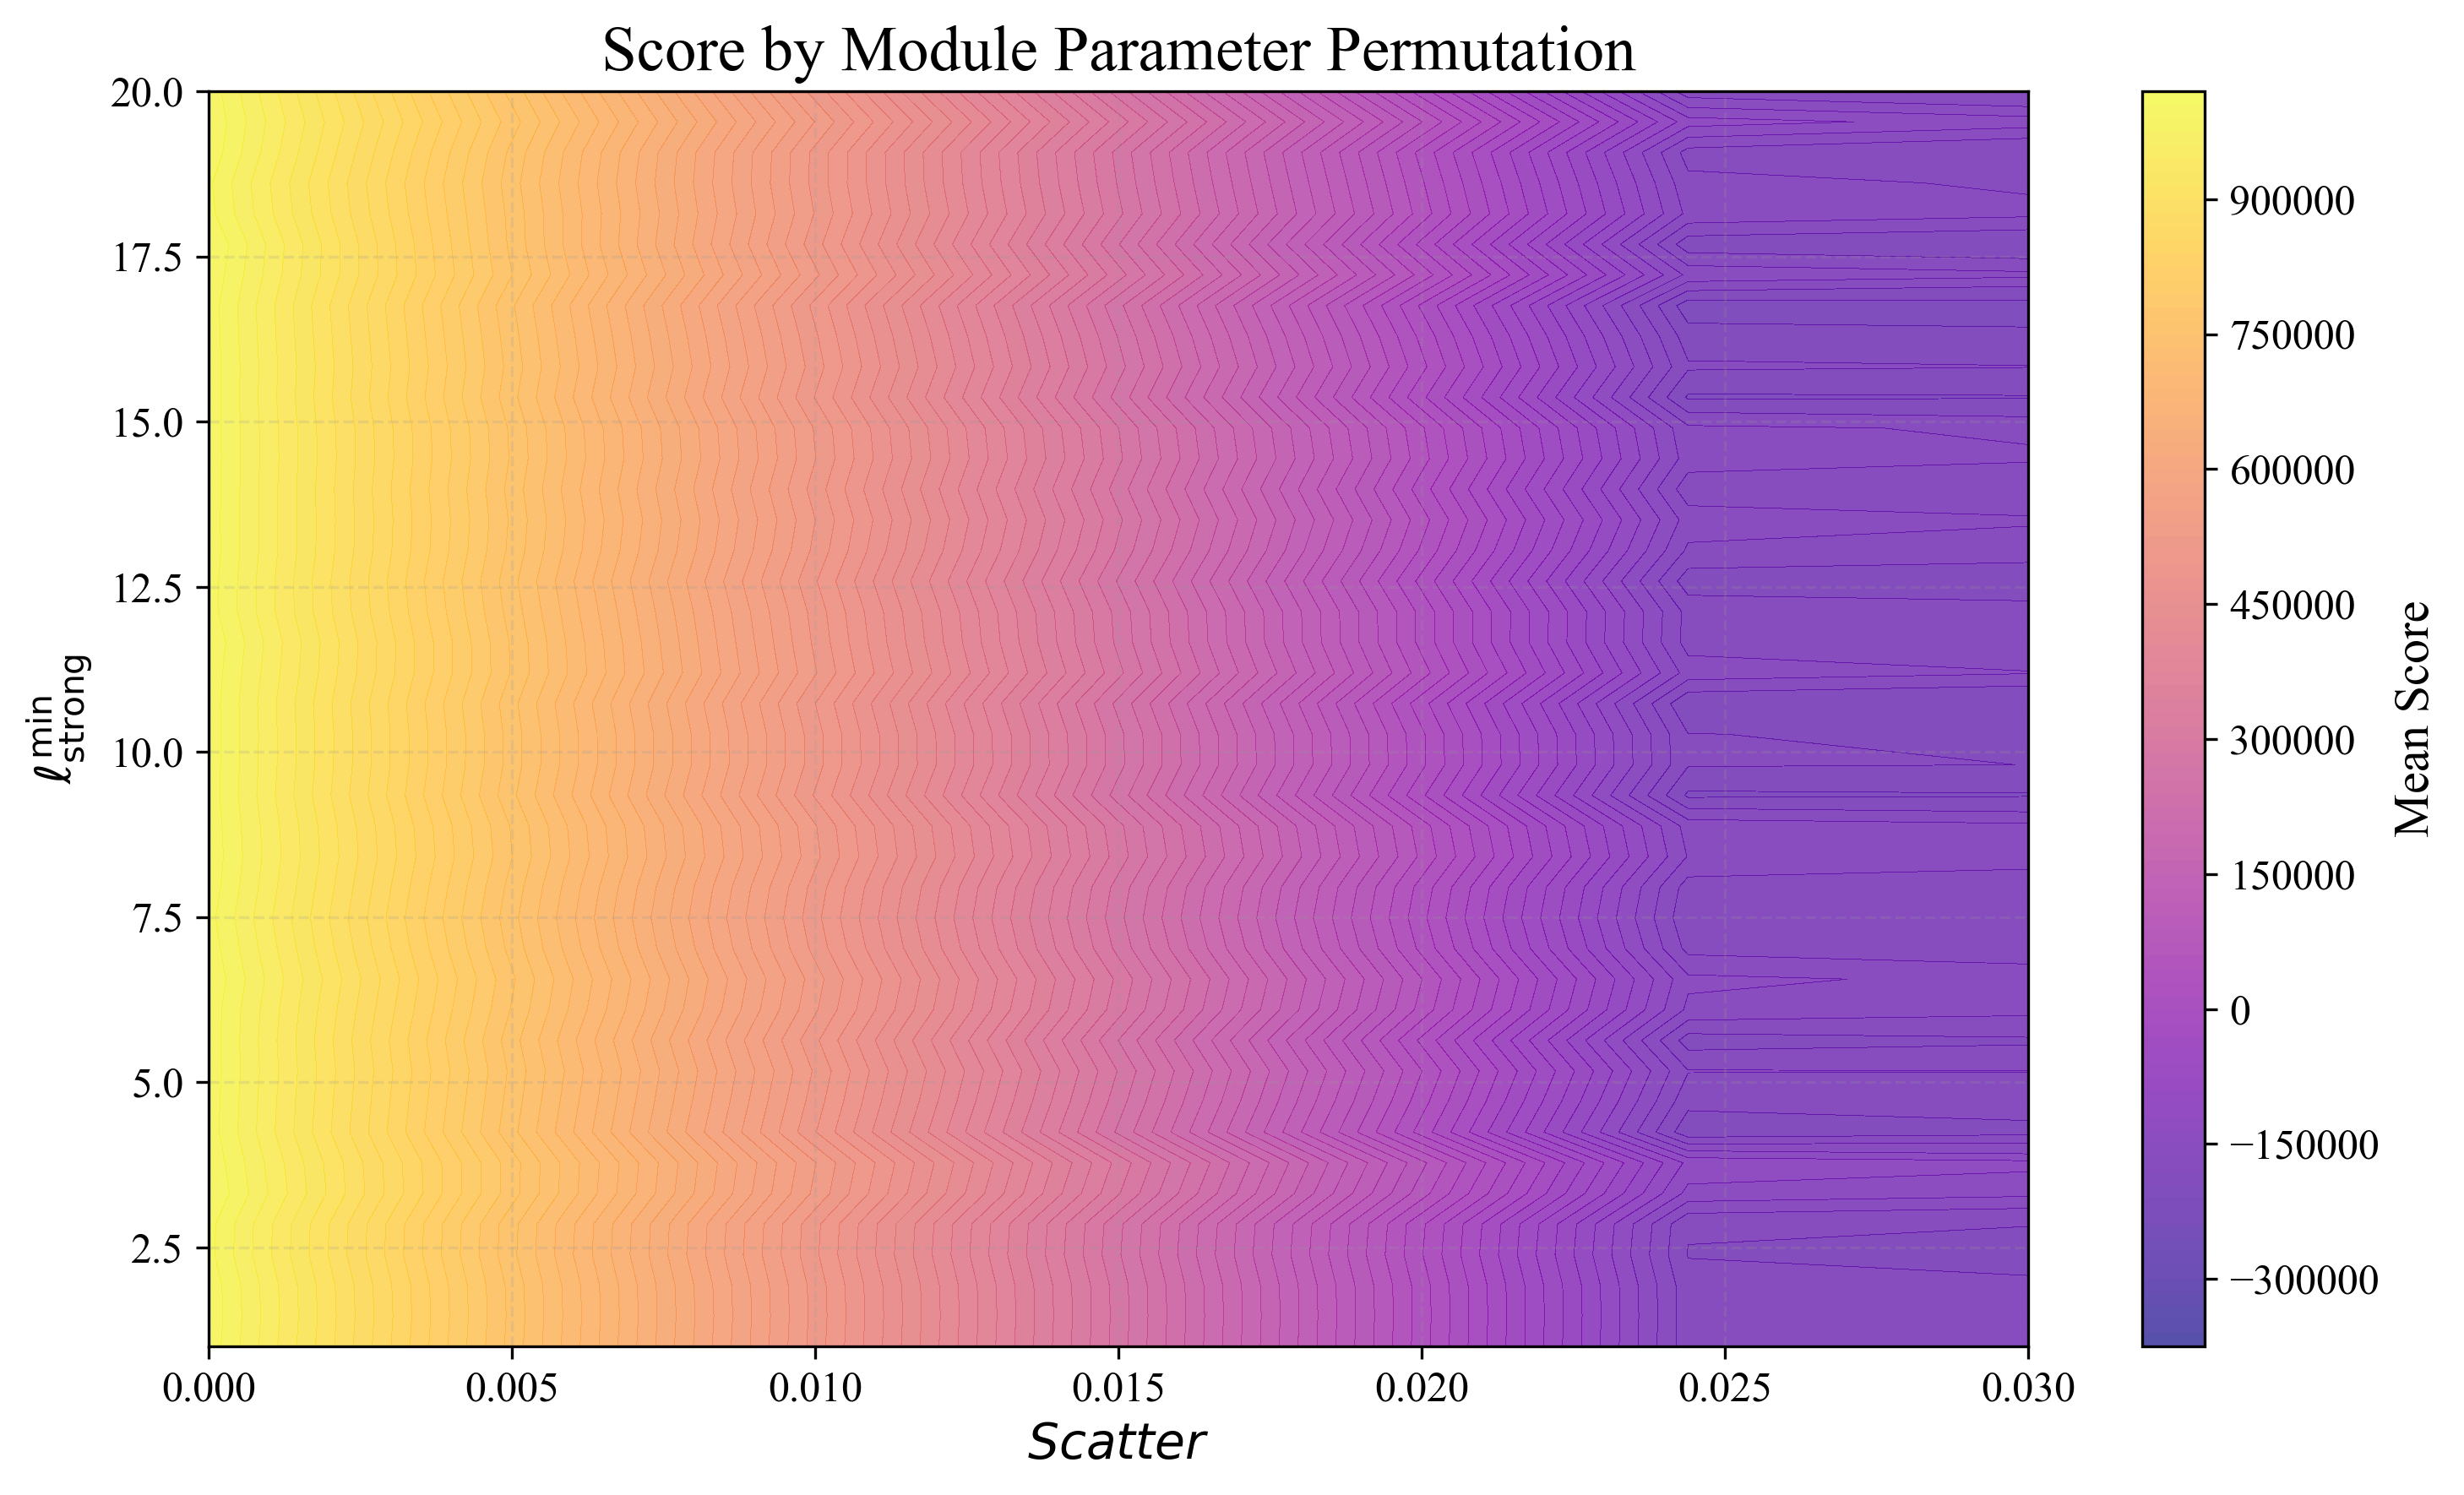

In [19]:
plot_score_landscape(
    df,
    x_param='scatter',
    y_param='min_strong_track_length',
    figsize=(10, 6),
    cmap='plasma',
    alpha=0.7,
    cbar_label='Mean Score',
    title="Score by Module Parameter Permutation",
    XTitle=r"$Scatter$",
    YTitle=r"$\ell_{\mathrm{strong}}^{\min}$",
    resolution=42,
    show_scatter=False     # Set to False if you want only the interpolated surface
)
